In [1]:
from helper_knn import *
from general_helper import multiclass_encoding

db = pd.read_csv('lc_db_processed.csv').drop(columns = 'Unnamed: 0')

db = pd.concat([db,
                pd.DataFrame(pd.DataFrame(db['pubchem2d'].values).\
                             apply(lambda x: x.str.replace('', ' ').str.strip().str.split(' '), 
                                                                        axis = 1)[0].to_list(),
                   columns = ['pub'+ str(i) for i in range(1,882)])],
               axis = 1)

numerical = ['atom_number', 'bonds_number','Mol', 'MorganDensity', 'LogP',
            'alone_atom_number', 'doubleBond', 'tripleBond', 'ring_number', 'oh_count', 'MeltingPoint', 'WaterSolubility']

categorical = ['obs_duration_mean',
               'conc1_type', 'exposure_type', 'control_type', 'media_type',
               'application_freq_unit', 'species', 'class', 'tax_order', 'family', 'genus']
db.drop(columns = categorical, inplace = True)

db = db.groupby('test_cas').agg('median').reset_index()

X = db.drop(columns = ['conc1_mean', 'test_cas'])
y = multiclass_encoding(db['conc1_mean'].copy())

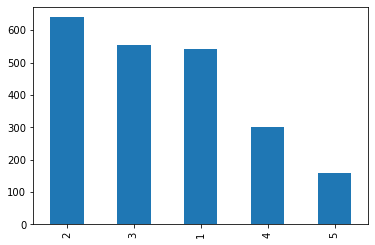

In [4]:
pd.Series(y).value_counts().plot.bar()

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression


kf = KFold(n_splits=5, shuffle=True, random_state = 5645)
accs = []

sens_micro = []
sens_macro = []
sens_weight = []

precs_micro = []
precs_macro = []
precs_weight = []

f1s_micro = []
f1s_macro = []
f1s_weight = []

for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])

    lrc = LogisticRegression(n_jobs = -1)
    lrc.fit(new_train, y_train)
    y_pred = lrc.predict(new_test)

    accs.append(accuracy_score(y_test, y_pred))
    
    sens_micro.append(recall_score(y_test, y_pred, average = 'micro'))
    sens_macro.append(recall_score(y_test, y_pred, average = 'macro'))
    sens_weight.append(recall_score(y_test, y_pred, average = 'weighted'))
    
    precs_micro.append(precision_score(y_test, y_pred, average = 'micro'))
    precs_macro.append(precision_score(y_test, y_pred, average = 'macro'))
    precs_weight.append(precision_score(y_test, y_pred, average = 'weighted'))
    
    f1s_micro.append(f1_score(y_test, y_pred, average = 'micro'))
    f1s_macro.append(f1_score(y_test, y_pred, average = 'macro'))
    f1s_weight.append(f1_score(y_test, y_pred, average = 'weighted'))
    
    
print('Accuracy:            ', np.mean(accs), 'se:', sem(accs), end = '\n\n')

print('Micro Recall:        ', np.mean(sens_micro), 'se:', sem(sens_micro))
print('Macro Recall:        ', np.mean(sens_macro), 'se:', sem(sens_macro))
print('Weighted Recall:     ', np.mean(sens_weight), 'se:', sem(sens_weight), end = '\n\n')

print('Micro Precision:     ', np.mean(precs_micro), 'se:', sem(precs_micro))
print('Macro Precision:     ', np.mean(precs_macro), 'se:', sem(precs_macro))
print('Weighted Precision:  ', np.mean(precs_weight), 'se:', sem(precs_weight), end = '\n\n')

print('Micro F1:            ', np.mean(f1s_micro), 'se: ', sem(f1s_micro))
print('Macro F1:            ', np.mean(f1s_macro), 'se: ', sem(f1s_macro))
print('Weighted F1:            ', np.mean(f1s_weight), 'se: ', sem(f1s_weight))

Accuracy:             0.44428142472561605 se: 0.009929819263646958

Micro Recall:         0.44428142472561605 se: 0.009929819263646958
Macro Recall:         0.37476484057554527 se: 0.009345441907649302
Weighted Recall:      0.44428142472561605 se: 0.009929819263646958

Micro Precision:      0.44428142472561605 se: 0.009929819263646958
Macro Precision:      0.43659479425512054 se: 0.01518845863418371
Weighted Precision:   0.4398610349483924 se: 0.010570179860421757

Micro F1:             0.44428142472561605 se:  0.009929819263646968
Macro F1:             0.3665435981874649 se:  0.013739508725209234
Weighted F1:             0.4164444137816538 se:  0.012370505453883008


# KNN

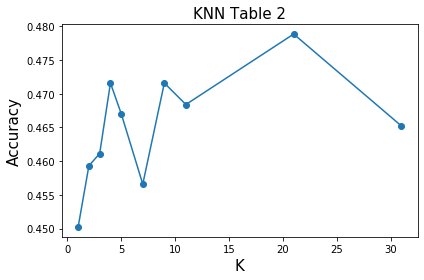

In [4]:
def knn_tab_2(X, y, k):
    
    accs = []

    sens_micro = []
    sens_macro = []
    sens_weight = []

    precs_micro = []
    precs_macro = []
    precs_weight = []

    f1s_micro = []
    f1s_macro = []
    f1s_weight = []

    kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        minmax = MinMaxScaler()
        minmax.fit(X_train[numerical])

        new_train = X_train.copy()
        new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

        new_test = X_test.copy()
        new_test.loc[:, numerical] = minmax.transform(X_test[numerical])


        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(new_train, y_train)
        y_pred = knn.predict(new_test)
        
        accs.append(accuracy_score(y_test, y_pred))
    
        sens_micro.append(recall_score(y_test, y_pred, average = 'micro'))
        sens_macro.append(recall_score(y_test, y_pred, average = 'macro'))
        sens_weight.append(recall_score(y_test, y_pred, average = 'weighted'))

        precs_micro.append(precision_score(y_test, y_pred, average = 'micro'))
        precs_macro.append(precision_score(y_test, y_pred, average = 'macro'))
        precs_weight.append(precision_score(y_test, y_pred, average = 'weighted'))

        f1s_micro.append(f1_score(y_test, y_pred, average = 'micro'))
        f1s_macro.append(f1_score(y_test, y_pred, average = 'macro'))
        f1s_weight.append(f1_score(y_test, y_pred, average = 'weighted'))
        
    return np.mean(accs), sem(accs), \
           np.mean(sens_micro), sem(sens_micro),\
           np.mean(sens_macro), sem(sens_macro),\
           np.mean(sens_weight), sem(sens_weight),\
           np.mean(precs_micro), sem(precs_micro),\
            np.mean(precs_macro), sem(precs_macro),\
            np.mean(precs_weight), sem(precs_weight),\
            np.mean(f1s_micro), sem(f1s_micro),\
            np.mean(f1s_macro), sem(f1s_macro),\
            np.mean(f1s_weight), sem(f1s_weight)
            

tabk = pd.DataFrame(index = ['Acc', 'St.err Acc',
                             'Sens (micro)', 'St.err Sens (micro)', 
                             'Sens (macro)', 'St.err Sens (macro)',
                             'Sens (weighted)', 'St.err Sens (weighted)',
                             'Prec (micro)', 'St.err Prec (micro)',
                             'Prec (macro)', 'St.err Prec (macro)',
                             'Prec (weighted)', 'St.err Prec (weighted)',
                             'F1 (micro)', 'St.err F1 (micro)',
                            'F1 (macro)', 'St.err F1 (macro)',
                            'F1 (weighted)', 'St.err F1 (weighted)'])

for i in [1,2,3,4,5,7,9,11,21,31]:
    tabk = pd.concat([tabk, pd.DataFrame(knn_tab_2(X,y,i),
                                         index = ['Acc', 'St.err Acc',
                             'Sens (micro)', 'St.err Sens (micro)', 
                             'Sens (macro)', 'St.err Sens (macro)',
                             'Sens (weighted)', 'St.err Sens (weighted)',
                             'Prec (micro)', 'St.err Prec (micro)',
                             'Prec (macro)', 'St.err Prec (macro)',
                             'Prec (weighted)', 'St.err Prec (weighted)',
                             'F1 (micro)', 'St.err F1 (micro)',
                            'F1 (macro)', 'St.err F1 (macro)',
                            'F1 (weighted)', 'St.err F1 (weighted)'])], axis = 1)

tabk = tabk.T.reset_index(drop = True)
tabk['K'] = pd.Series([1,2,3,4,5,7,9,11,21,31])

import matplotlib.pyplot as plt

plt.plot(tabk['K'], tabk['Acc'], '-o')
plt.xlabel('K', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('KNN Table 2', fontsize = 15)
plt.tight_layout()
# plt.savefig('knn_table2.png')

In [8]:
print(r'''\begin{table}[]
\centering
\begin{tabular}{c||c|c|c|c}
K & Accuracy & Recall (Micro) & Recall (Macro) & Recall (Weighted) & Precision (Micro) & Precision (Macro) & Precision (Weighted) & F1 (Micro) & F1 (Macro) & F1 (Weighted) \\ \hline \hline''')
for i in tabk[['K', 'Acc',
               'Sens (micro)', 'Sens (macro)', 'Sens (weighted)',
               'Prec (micro)', 'Prec (macro)', 'Prec (weighted)',
               'F1 (micro)', 'F1 (macro)', 'F1 (weighted)']].values:
    for j in i:
        if i[len(i)-1] == j:
            print(np.around(j,3), r'\\')
        elif i[0] == j:
            print(int(j), '&', end = ' ')
        else:
            print(np.around(j,4), '&', end = ' ')
        
print(r'''\end{tabular}
\end{table}''')

\begin{table}[]
\centering
\begin{tabular}{c||c|c|c|c}
K & Accuracy & Recall (Micro) & Recall (Macro) & Recall (Weighted) & Precision (Micro) & Precision (Macro) & Precision (Weighted) & F1 (Micro) & F1 (Macro) & F1 (Weighted) \\ \hline \hline
1 & 0.4502 & 0.4502 & 0.4387 & 0.4502 & 0.4502 & 0.4354 & 0.4534 & 0.4502 & 0.4352 & 0.45 \\
2 & 0.4593 & 0.4593 & 0.4099 & 0.4593 & 0.4593 & 0.4752 & 0.4583 & 0.4593 & 0.415 & 0.443 \\
3 & 0.4611 & 0.4611 & 0.4287 & 0.4611 & 0.4611 & 0.4571 & 0.4538 & 0.4611 & 0.431 & 0.449 \\
4 & 0.4716 & 0.4716 & 0.438 & 0.4716 & 0.4716 & 0.4639 & 0.4658 & 0.4716 & 0.4415 & 0.462 \\
5 & 0.467 & 0.467 & 0.4333 & 0.467 & 0.467 & 0.4589 & 0.461 & 0.467 & 0.4364 & 0.458 \\
7 & 0.4566 & 0.4566 & 0.4217 & 0.4566 & 0.4566 & 0.444 & 0.4486 & 0.4566 & 0.4236 & 0.446 \\
9 & 0.4716 & 0.4716 & 0.4332 & 0.4716 & 0.4716 & 0.458 & 0.4623 & 0.4716 & 0.4361 & 0.46 \\
11 & 0.4684 & 0.4684 & 0.4314 & 0.4684 & 0.4684 & 0.4576 & 0.4619 & 0.4684 & 0.4339 & 0.458 \\
21 & 0.4789 & 0.

# Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier

accs = []

sens_micro = []
sens_macro = []
sens_weight = []

precs_micro = []
precs_macro = []
precs_weight = []

f1s_micro = []
f1s_macro = []
f1s_weight = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    
    rfc = RandomForestClassifier(n_estimators=1000)
    rfc.fit(new_train, y_train)
    y_pred = rfc.predict(new_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    
    sens_micro.append(recall_score(y_test, y_pred, average = 'micro'))
    sens_macro.append(recall_score(y_test, y_pred, average = 'macro'))
    sens_weight.append(recall_score(y_test, y_pred, average = 'weighted'))
    
    precs_micro.append(precision_score(y_test, y_pred, average = 'micro'))
    precs_macro.append(precision_score(y_test, y_pred, average = 'macro'))
    precs_weight.append(precision_score(y_test, y_pred, average = 'weighted'))
    
    f1s_micro.append(f1_score(y_test, y_pred, average = 'micro'))
    f1s_macro.append(f1_score(y_test, y_pred, average = 'macro'))
    f1s_weight.append(f1_score(y_test, y_pred, average = 'weighted'))
    
print('Accuracy:            ', np.mean(accs), 'se:', sem(accs), end = '\n\n')

print('Micro Recall:        ', np.mean(sens_micro), 'se:', sem(sens_micro))
print('Macro Recall:        ', np.mean(sens_macro), 'se:', sem(sens_macro))
print('Weighted Recall:     ', np.mean(sens_weight), 'se:', sem(sens_weight), end = '\n\n')

print('Micro Precision:     ', np.mean(precs_micro), 'se:', sem(precs_micro))
print('Macro Precision:     ', np.mean(precs_macro), 'se:', sem(precs_macro))
print('Weighted Precision:  ', np.mean(precs_weight), 'se:', sem(precs_weight), end = '\n\n')

print('Micro F1:            ', np.mean(f1s_micro), 'se: ', sem(f1s_micro))
print('Macro F1:            ', np.mean(f1s_macro), 'se: ', sem(f1s_macro))
print('Weighted F1:         ', np.mean(f1s_weight), 'se: ', sem(f1s_weight))

Accuracy:             0.4993145578794781 se: 0.010585287670101187

Micro Recall:         0.4993145578794781 se: 0.010585287670101187
Macro Recall:         0.4693548904922216 se: 0.010187832160695146
Weighted Recall:      0.4993145578794781 se: 0.010585287670101187

Micro Precision:      0.4993145578794781 se: 0.010585287670101187
Macro Precision:      0.49425078169765585 se: 0.009891775134244678
Weighted Precision:   0.5009297686107669 se: 0.010735428807719133

Micro F1:             0.4993145578794781 se:  0.010585287670101187
Macro F1:             0.47472880892511504 se:  0.010912435301879991
Weighted F1:             0.4953151110087962 se:  0.011571348777196554


# Simple RASAR

In [6]:
from sklearn.linear_model import LogisticRegression

def right_neighbor(neighbors, X_train, X_train_i):
    # IDX Neighbors
    idx_neigh_0 = pd.DataFrame(neighbors[1])[0].apply(lambda x: X_train_i.iloc[x].name)
    idx_neigh_1 = pd.DataFrame(neighbors[1])[1].apply(lambda x: X_train_i.iloc[x].name)
    
    idx_neigh = idx_neigh_0.copy()
    
    # dove l'indice del primo vicino risulta essere uguale a se stesso lo sostituisco con il secondo vicino
    idx_neigh[X_train.index == idx_neigh_0] = idx_neigh_1[X_train.index == idx_neigh_0].values
    
    # Distance from the Nearest Neighbor that is NOT itself
    dist_0 = pd.DataFrame(neighbors[0])[0]
    dist_1 = pd.DataFrame(neighbors[0])[1]
    
    distance = dist_0.copy()
    distance[X_train.index == idx_neigh_0] = dist_1[X_train.index == idx_neigh_0].values
    
    return idx_neigh, distance

In [7]:
accs = []
sens = []
specs = []
precs = []
f1s = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

for train_index, test_index in kf.split(X):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    X_train0 = X_train[y_train == 0].copy()
    X_train1 = X_train[y_train == 1].copy()

    ## DF Train
    ##################################
    ### VA FATTO PER OGNI CLASSE #####
    ##################################
    

#     knn0 = KNeighborsClassifier(n_neighbors = 2)
#     knn0.fit(X_train0, y_train[y_train == 0])

#     neigh_train0 = knn0.kneighbors(X_train, return_distance = True)
#     idx_neigh0, dist0 = right_neighbor(neigh_train0, X_train, X_train0)

#     knn1 = KNeighborsClassifier(n_neighbors = 2)
#     knn1.fit(X_train1, y_train[y_train == 1])

#     neigh_train1 = knn1.kneighbors(X_train, return_distance = True)
#     idx_neigh1, dist1 = right_neighbor(neigh_train1, X_train, X_train1)

#     df_rasar_train = pd.DataFrame({'idx_train': X_train.index.values,
#                           'label_train': y_train,
#                           'idx_neigh0': idx_neigh0.values,
#                           'dist_neigh0': dist0,       
#                           'idx_neigh1': idx_neigh1.values,
#                           'dist_neigh1': dist1})

    # DF test
#     knn0 = KNeighborsClassifier(n_neighbors = 1)
#     knn0.fit(X_train0, y_train[y_train == 0])
#     neigh_test0 = knn0.kneighbors(X_test, return_distance = True)
#     idx_neigh_test0 = pd.DataFrame(neigh_test0[1])[0].apply(lambda x: X_train0.iloc[x].name)

#     knn1 = KNeighborsClassifier(n_neighbors = 1)
#     knn1.fit(X_train1, y_train[y_train == 1])
#     neigh_test1 = knn1.kneighbors(X_test, return_distance = True)
#     idx_neigh_test1 = pd.DataFrame(neigh_test1[1])[0].apply(lambda x: X_train1.iloc[x].name)

#     df_rasar_test = pd.DataFrame({'idx_test': X_test.index.values,
#                   'label_test': y_test,
#                   'idx_neigh0': idx_neigh_test0.values,
#                   'dist_neigh0': neigh_test0[0].ravel(),
#                   'idx_neigh1': idx_neigh_test1.values,
#                   'dist_neigh1': neigh_test1[0].ravel()})


    lrc = LogisticRegression()
    lrc.fit(df_rasar_train[['dist_neigh0','dist_neigh1']], y_train)
    y_pred = lrc.predict(df_rasar_test[['dist_neigh0','dist_neigh1']])
    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy:    0.8071878235659558 se: 0.007902130855140388
Sensitivity: 0.11776220360958403 se: 0.027228724768366477
Specificity: 0.9909122276029055 se: 0.005779688436644699
Precision:   0.8502742946708464 se: 0.0707112101265878
F1: 0.19786296869981665 se:  0.03769662648026407


# Simple RASAR con RF

In [9]:
from sklearn.ensemble import RandomForestClassifier

accs = []
sens = []
specs = []
precs = []
f1s = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

for train_index, test_index in kf.split(X):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    X_train0 = X_train[y_train == 0].copy()
    X_train1 = X_train[y_train == 1].copy()

    ## DF Train
    ##################################
    ### VA FATTO PER OGNI CLASSE #####
    ##################################

#     knn0 = KNeighborsClassifier(n_neighbors = 2)
#     knn0.fit(X_train0, y_train[y_train == 0])

#     neigh_train0 = knn0.kneighbors(X_train, return_distance = True)
#     idx_neigh0, dist0 = right_neighbor(neigh_train0, X_train, X_train0)

#     knn1 = KNeighborsClassifier(n_neighbors = 2)
#     knn1.fit(X_train1, y_train[y_train == 1])

#     neigh_train1 = knn1.kneighbors(X_train, return_distance = True)
#     idx_neigh1, dist1 = right_neighbor(neigh_train1, X_train, X_train1)

#     df_rasar_train = pd.DataFrame({'idx_train': X_train.index.values,
#                           'label_train': y_train,
#                           'idx_neigh0': idx_neigh0.values,
#                           'dist_neigh0': dist0,       
#                           'idx_neigh1': idx_neigh1.values,
#                           'dist_neigh1': dist1})

#     # DF test
#     knn0 = KNeighborsClassifier(n_neighbors = 1)
#     knn0.fit(X_train0, y_train[y_train == 0])
#     neigh_test0 = knn0.kneighbors(X_test, return_distance = True)
#     idx_neigh_test0 = pd.DataFrame(neigh_test0[1])[0].apply(lambda x: X_train0.iloc[x].name)

#     knn1 = KNeighborsClassifier(n_neighbors = 1)
#     knn1.fit(X_train1, y_train[y_train == 1])
#     neigh_test1 = knn1.kneighbors(X_test, return_distance = True)
#     idx_neigh_test1 = pd.DataFrame(neigh_test1[1])[0].apply(lambda x: X_train1.iloc[x].name)

#     df_rasar_test = pd.DataFrame({'idx_test': X_test.index.values,
#                   'label_test': y_test,
#                   'idx_neigh0': idx_neigh_test0.values,
#                   'dist_neigh0': neigh_test0[0].ravel(),
#                   'idx_neigh1': idx_neigh_test1.values,
#                   'dist_neigh1': neigh_test1[0].ravel()})


    clf = RandomForestClassifier()
    clf.fit(df_rasar_train[['dist_neigh0','dist_neigh1']], y_train)
    y_pred = clf.predict(df_rasar_test[['dist_neigh0','dist_neigh1']])
    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy:    0.7794491613170429 se: 0.010117353018028206
Sensitivity: 0.2611307492061531 se: 0.028706753973234293
Specificity: 0.917030366269256 se: 0.005301088697124177
Precision:   0.4506295739288303 se: 0.02605383872708216
F1:          0.3294599607524981 se:  0.02968803493173642
